In [1]:
%load_ext autoreload
%autoreload 2

import torch
import pyro
from pyro import distributions as dist
from pyro import poutine
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
#sns.set()

# Model

## Toy model

Input X - corresponds to any kind of phase space input - some **distribution** with prior.
Input $\mu$ - corresponds to parameters of surrogate, ie - size of detector, magnetic field, etc. - a **number**.

Define some functions f, g - those can be varied. Probably, bettern to stick with some types of them, ie:
continous, pereodic, polynomial, ...

$$X \sim U(x_{min}, x_{max}), \ \ \mu \sim \delta(\mu - \mu_0) $$

$$latent\_x \sim  \mathcal{N} (latent\_x | X, 1)$$

$$latent\_mu \sim \mathcal{N}(latent\_mu |\mu, 1)$$

$$ f(\alpha) = a + b \alpha + c sin(\alpha) $$
$$ g(\alpha) = abs(d * \alpha) $$

$$y \sim \mathcal{N}(y|f(latent\_x), g(latent\_mu))$$

### Problem statement

1. Fit GAN/GP/NV to match p(y|X,mu)

2. Solve optimisaiton problem of the choise:
 - $argmin_{mu} (y - Y_0) ^2 $
 - $argmax_{mu} p(y|mu) = \int p(y|X,mu) p(X) dx$
 - $etc$



## Make model with `pyro`

In [36]:
class YModel(object):
    def __init__(self, x_range=(-10,10), init_mu = 0):
        self.mu_dist = dist.Delta(torch.tensor(float(init_mu), requires_grad=True))
        self.x_dist = dist.Uniform(*x_range) 
    
    @staticmethod
    def f(x, a=1, b=1, c=1):
        return a + b * x + c * torch.sin(x)
    @staticmethod
    def g(x, d=1):
        return torch.abs(d * x)
    
    def sample(self):
        mu = pyro.sample('mu', self.mu_dist)
        X = pyro.sample('X', self.x_dist)

        latent_x = pyro.sample('latent_x', dist.Normal(X, 1))
        latent_x = self.f(latent_x)

        latent_mu = pyro.sample('latent_mu', dist.Normal(mu, 1))
        latent_mu = self.g(latent_mu)
        return pyro.sample('y', dist.Normal(latent_x, latent_mu))
    
    def make_condition_sample(self, data):
        self.condition_sample = poutine.condition(self.sample, data=data)
    
    def condition_sample(self):
        return self.condition_sample()

## Investigation of the model

In [37]:
y_sampler = YModel()

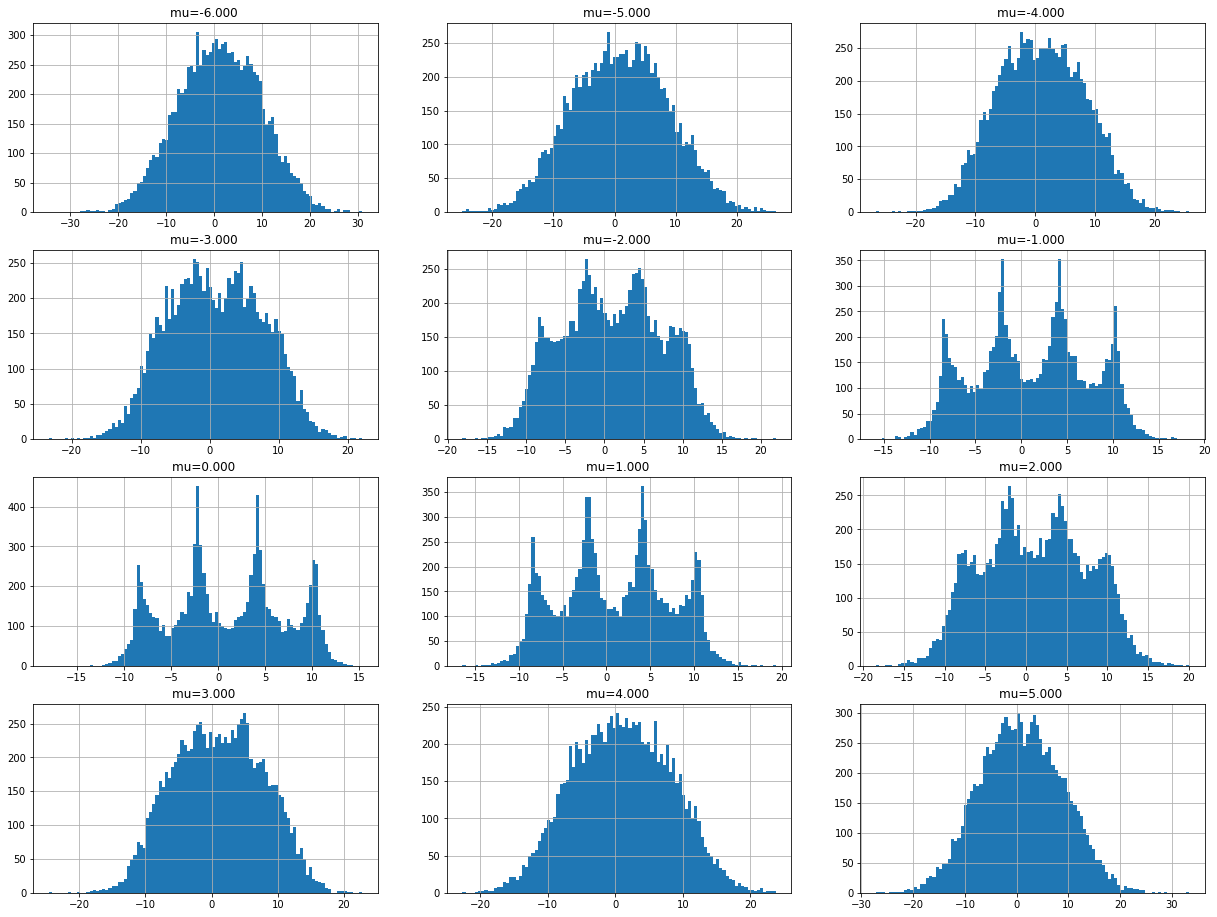

In [46]:
plt.figure(figsize=(21,16))
mu = list(range(-6, 6, 1))
for i in range(4):
    for j in range(3):
        plt.subplot(4,3, i*3 + j + 1)
        y_sampler.make_condition_sample({'mu': torch.tensor(float(mu[i*3 + j]))})
        plt.hist([y_sampler.condition_sample().item() for _ in range(10000)], bins=100);
        plt.grid()
        #plt.legend()
        plt.title("mu={:.3f} ".format(mu[i*3 + j]))

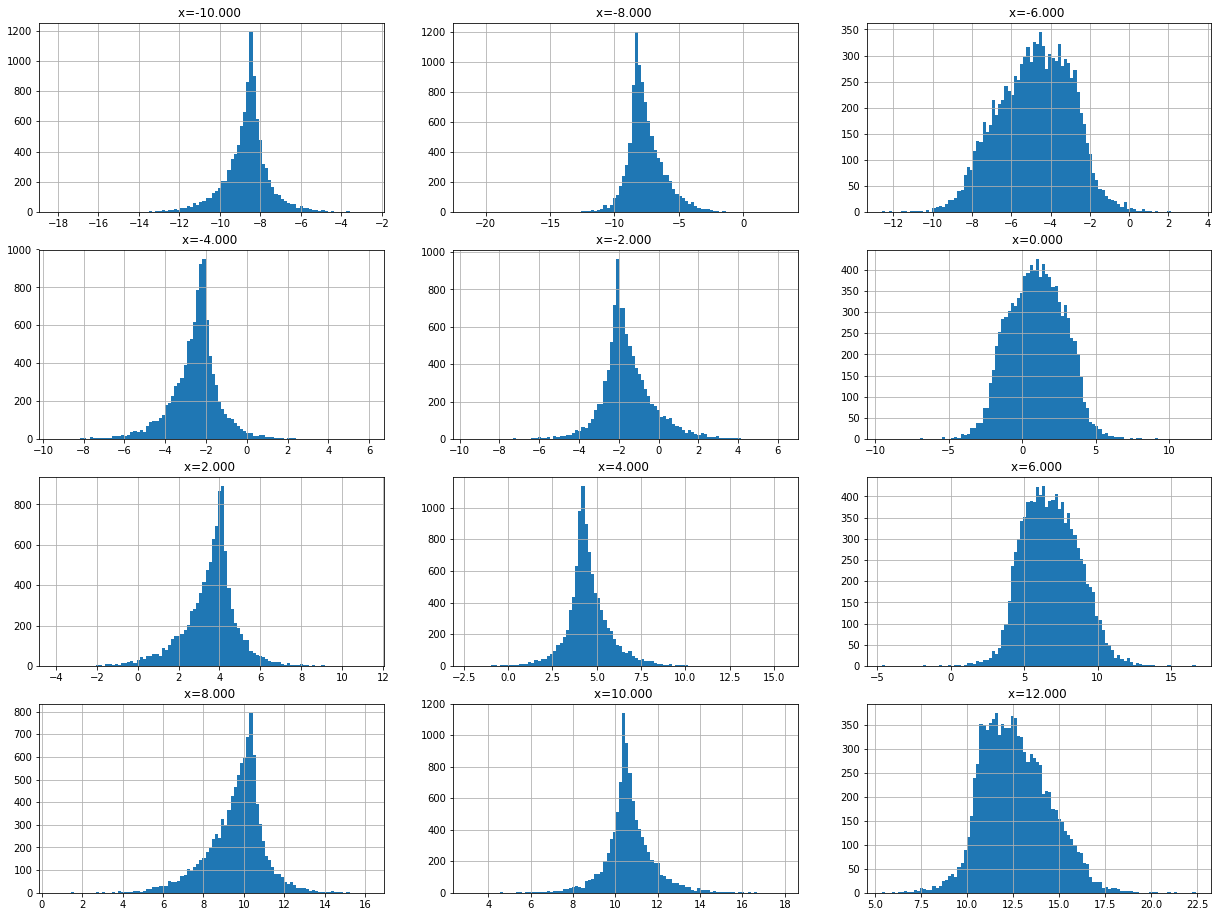

In [38]:
plt.figure(figsize=(21,16))
x_r = list(range(-10, 15, 2))
for i in range(4):
    for j in range(3):
        plt.subplot(4,3, i*3 + j + 1)
        y_sampler.make_condition_sample({'X': torch.tensor(float(x_r[i*3 + j]))})
        plt.hist([y_sampler.condition_sample().item() for _ in range(10000)], bins=100);
        plt.grid()
        #plt.legend()
        plt.title("x={:.3f} ".format(x_r[i*3 + j]))

## Statistic of interest

$$r = \frac{1}{N} \sum\limits_{i=0}^{N} || y_i - Y ||_2^2$$

In [39]:
def R(ys: torch.tensor, Y_0=-5):
    return (ys - Y_0).pow(2).mean()

## Approaches to solve the problem

### First one

  1. Make approximation of this model:

  $$p(y | \mu)$$

  With GANs or some other techniques.
  

  2. Sample $\{ y_i \}_{i=0}^{B} \sim p(y | \mu)$
  
  
  3. Calc $r = R(\{ y_i \}_{i=0}^{B})$
  
  
  4. Find $\frac{\partial r}{\partial \mu}$
  
### Second one


  1. Make approximation of this model:

  $$p(r | \mu)$$
  
  
  2. Sample $r \sim p(r | \mu)$
  
  
  3. Find $\frac{\partial r}{\partial \mu}$

In [41]:
import numpy as np

rs = []
mus = np.linspace(-100, 100, 100)
for mu in tqdm.tqdm(mus):
    y_sampler.make_condition_sample({'mu': torch.tensor(mu)})
    samples = torch.stack([y_sampler.condition_sample() for _ in range(1000)])
    rs.append(R(samples).item())

100%|██████████| 100/100 [00:29<00:00,  3.54it/s]


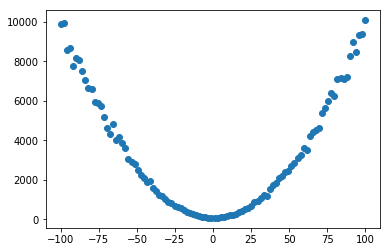

In [44]:
plt.scatter(mus, rs)

In [49]:
rs = []
xs = np.linspace(-100, 100, 100)
for x in tqdm.tqdm(xs):
    y_sampler.make_condition_sample({'X': torch.tensor(x)})
    samples = torch.stack([y_sampler.condition_sample() for _ in range(1000)])
    rs.append(R(samples).item())

100%|██████████| 100/100 [00:31<00:00,  3.41it/s]


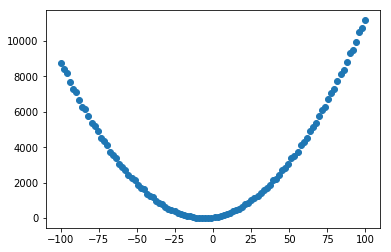

In [50]:
plt.scatter(mus, rs)